# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [3]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


In [8]:
# pandas jupyter notebook formatting 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

The objective is to build a predictive model that accurately estimates a property’s assessed tax value `taxvaluedollarcnt` based on its features. In business terms, this project will support Zillow’s efforts to improve property valuation algorithms like the "Zestimate". Accurate tax value predictions will help Zillow offer reliable price estimates to users, support better investment analysis, and potentially attract partnerships with lenders or real estate agencies relying on property analytics.


**1.2:**  How will your solution be used?

The regression model will be integrated into Zillow's backend engine to automatically estimate the value of its listef properties in situations where there is missing, outdated, or incorrect data. This can enhance user-facing tools, like property detail pages and pricing heat maps, and assist internal teams in identifying undervalued or overvalued listings. Additionally, the marketing team could also use the insights to target promotions to areas with high valuation discrepancies or growing value trends.

**1.3:**  How should success (or failure) be measured?

The success of this regression model should be measured using evaluation metrics such as RMSE (Root Mean Squared Error) or MAE (Mean Absolute Error) on a holdout test set. A lower RMSE indicates more accurate predictions. From a buisiness perspective, success also means improving the trustworthiness of Zillow's automatic valuations - ideally reducing the gap between predicted and actual tax values. We can measure failure if the model performs no better than existing appraisal methods, or if it fails to generalize beyond the training data.

 - add source for current prediction accuracies to compare our final model

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [9]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [30]:
print(f"{df.shape[0]} rows x {df.shape[1]} columns")
for column in df.columns:
    print(f"{column}: {len(df[column].unique())}")

77613 rows x 55 columns
parcelid: 77414
airconditioningtypeid: 6
architecturalstyletypeid: 6
basementsqft: 44
bathroomcnt: 23
bedroomcnt: 17
buildingclasstypeid: 3
buildingqualitytypeid: 13
calculatedbathnbr: 22
decktypeid: 2
finishedfloor1squarefeet: 1788
calculatedfinishedsquarefeet: 4973
finishedsquarefeet12: 4869
finishedsquarefeet13: 14
finishedsquarefeet15: 1725
finishedsquarefeet50: 1808
finishedsquarefeet6: 351
fips: 4
fireplacecnt: 6
fullbathcnt: 14
garagecarcnt: 15
garagetotalsqft: 840
hashottuborspa: 2
heatingorsystemtypeid: 11
latitude: 64039
longitude: 62462
lotsizesquarefeet: 18849
poolcnt: 2
poolsizesum: 263
pooltypeid10: 2
pooltypeid2: 2
pooltypeid7: 2
propertycountylandusecode: 76
propertylandusetypeid: 14
propertyzoningdesc: 1908
rawcensustractandblock: 39189
regionidcity: 176
regionidcounty: 4
regionidneighborhood: 481
regionidzip: 390
roomcnt: 17
storytypeid: 2
threequarterbathnbr: 5
typeconstructiontypeid: 5
unitcnt: 9
yardbuildingsqft17: 541
yardbuildingsqft26: 60

In [ ]:
categorical_columns = []
for column in df.columns:
    if df[column].dtype != "float64" and df[column].dtype != "int64":
        print(f"{column}: {df[column].unique()}")
        categorical_columns.append(column)

print(f"\nCategorical Columns:")
for column in categorical_columns:
    print(f"{len(df[column].unique())} unique values in {column}")

hashottuborspa: [nan True]
propertycountylandusecode: ['122' '1110' '0101' '010C' '1129' '0100' '38' '34' '1111' '012C' '010V'
 '1' '0103' '010D' '0200' '010E' '0300' '96' '0104' '0400' '01DC' '01HC'
 nan '1321' '1410' '0108' '1128' '010G' '1720' '010H' '1210' '0102' '010F'
 '010M' '1117' '0201' '0700' '1722' '73' '0109' '0301' '01HE' '135' '0204'
 '0401' '070D' '0113' '0133' '0131' '1432' '040G' '1112' '1222' '1310'
 '1120' '0111' '1116' '1421' '0110' '0105' '012E' '0141' '1333' '0115'
 '040V' '010L' '040B' '012D' '0114' '0203' '030G' '0130' '105' '020G'
 '020M' '020E']
propertyzoningdesc: [nan 'LCR110000*' 'LAR3' ... 'HAR4-R2*' 'LCR1VV' 'BFA15000*']
fireplaceflag: [nan True]
taxdelinquencyflag: [nan 'Y']

Categorical Columns:
2 unique values in hashottuborspa
76 unique values in propertycountylandusecode
1908 unique values in propertyzoningdesc
2 unique values in fireplaceflag
2 unique values in taxdelinquencyflag


In [23]:
missing_vals_percentage = df.isnull().mean() * 100
missing_vals_percentage

parcelid                         0.000000
airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910
hashottuborspa                  98.017085
heatingorsystemtypeid           36

In [26]:
# If the data is missing over missing_threshold's percentage, then we can disregard the data for modelling.
missing_threshold = 70
high_missing = missing_vals_percentage[missing_vals_percentage > missing_threshold].sort_values(ascending=False)
print(high_missing)


buildingclasstypeid         99.980673
finishedsquarefeet13        99.945885
basementsqft                99.935578
storytypeid                 99.935578
yardbuildingsqft26          99.909809
fireplaceflag               99.778388
architecturalstyletypeid    99.733292
typeconstructiontypeid      99.712677
finishedsquarefeet6         99.502661
pooltypeid10                99.400874
decktypeid                  99.208895
poolsizesum                 98.880342
pooltypeid2                 98.616211
hashottuborspa              98.017085
yardbuildingsqft17          96.916754
taxdelinquencyflag          96.263513
taxdelinquencyyear          96.263513
finishedsquarefeet15        96.099880
finishedsquarefeet50        92.221664
finishedfloor1squarefeet    92.221664
fireplacecnt                89.320088
threequarterbathnbr         86.978985
pooltypeid7                 80.571554
poolcnt                     79.160708
numberofstories             77.324675
dtype: float64


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

### Answer
hashottuborspa

propertycountylandusecode

propertyzoningdesc

fireplaceflag

taxdelinquencyflag

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

### Answer
`parcelid` - Just a unique identifier, probably doesnt have any predictive value.

`rawcensustractandblock` - Census tracts and blocks are geographic units used by the U.S. Census Bureau for data collection and tabulation, they won't help predict value, we have the `regionidx` for that.

`taxdelinquencyflag` - this might seem useful, but being delinquent on taxes is owner-specific, not structural. So it shoulfd be excluded.

`taxdelinquencyyear` - same as `taxdelinquencyflag`

`assessmentyear` - this likely will introduce bias into the model since a lot of the rows will have the same value. It also makes no difference to the house value WHEN the property was assesed.

`fips` Federal Information Processing Standards code, uniquely identifying counties and county equivalents - not relevant to tax values


**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

The following features are missing more than 70% of their values, which means they effectively contribute nothing. These features should be discarded from the dataset prior to training a model
| Feature Name               | % Missing Values |
|---------------------------|------------------|
| buildingclasstypeid       | 99.98%           |
| finishedsquarefeet13      | 99.95%           |
| basementsqft              | 99.94%           |
| storytypeid               | 99.94%           |
| yardbuildingsqft26        | 99.91%           |
| fireplaceflag             | 99.78%           |
| architecturalstyletypeid  | 99.73%           |
| typeconstructiontypeid    | 99.71%           |
| finishedsquarefeet6       | 99.50%           |
| pooltypeid10              | 99.40%           |
| decktypeid                | 99.21%           |
| poolsizesum               | 98.88%           |
| pooltypeid2               | 98.62%           |
| hashottuborspa            | 98.02%           |
| yardbuildingsqft17        | 96.92%           |
| taxdelinquencyflag        | 96.26%           |
| taxdelinquencyyear        | 96.26%           |
| finishedsquarefeet15      | 96.10%           |
| finishedsquarefeet50      | 92.22%           |
| finishedfloor1squarefeet  | 92.22%           |
| fireplacecnt              | 89.32%           |
| threequarterbathnbr       | 86.98%           |
| pooltypeid7               | 80.57%           |
| poolcnt                   | 79.16%           |
| numberofstories           | 77.32%           |

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

### Answer
| Column                      | Unique Values | Why it’s Useless                                                                        |
| --------------------------- | ------------- | ---------------------------------------------------------------------------------------------- |
| `parcelid`                  | 77,414        | Nearly unique per row, it's just an ID.                                                       |
| `latitude`                  | 64,039        | High cardinality, slight rounding errors make it nearly unique. Might be useful only if grouped or binned. |
| `longitude`                 | 62,462        | Same as latitude. Raw values unlikely to generalize well.                                      |
| `rawcensustractandblock`    | 39,189        | Essentially a long encoded geographic string — overlaps with other geographic fields.          |
| `censustractandblock`       | 39,007        | Similar issue as `rawcensustractandblock`.                                                                        |
| `propertyzoningdesc`        | 1,908         | While it may contain meaningful categories, it's likely too granular unless grouped.           |
| `propertycountylandusecode` | 76            | COULD be useful but should probably be grouped/categorized first.                   |


### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

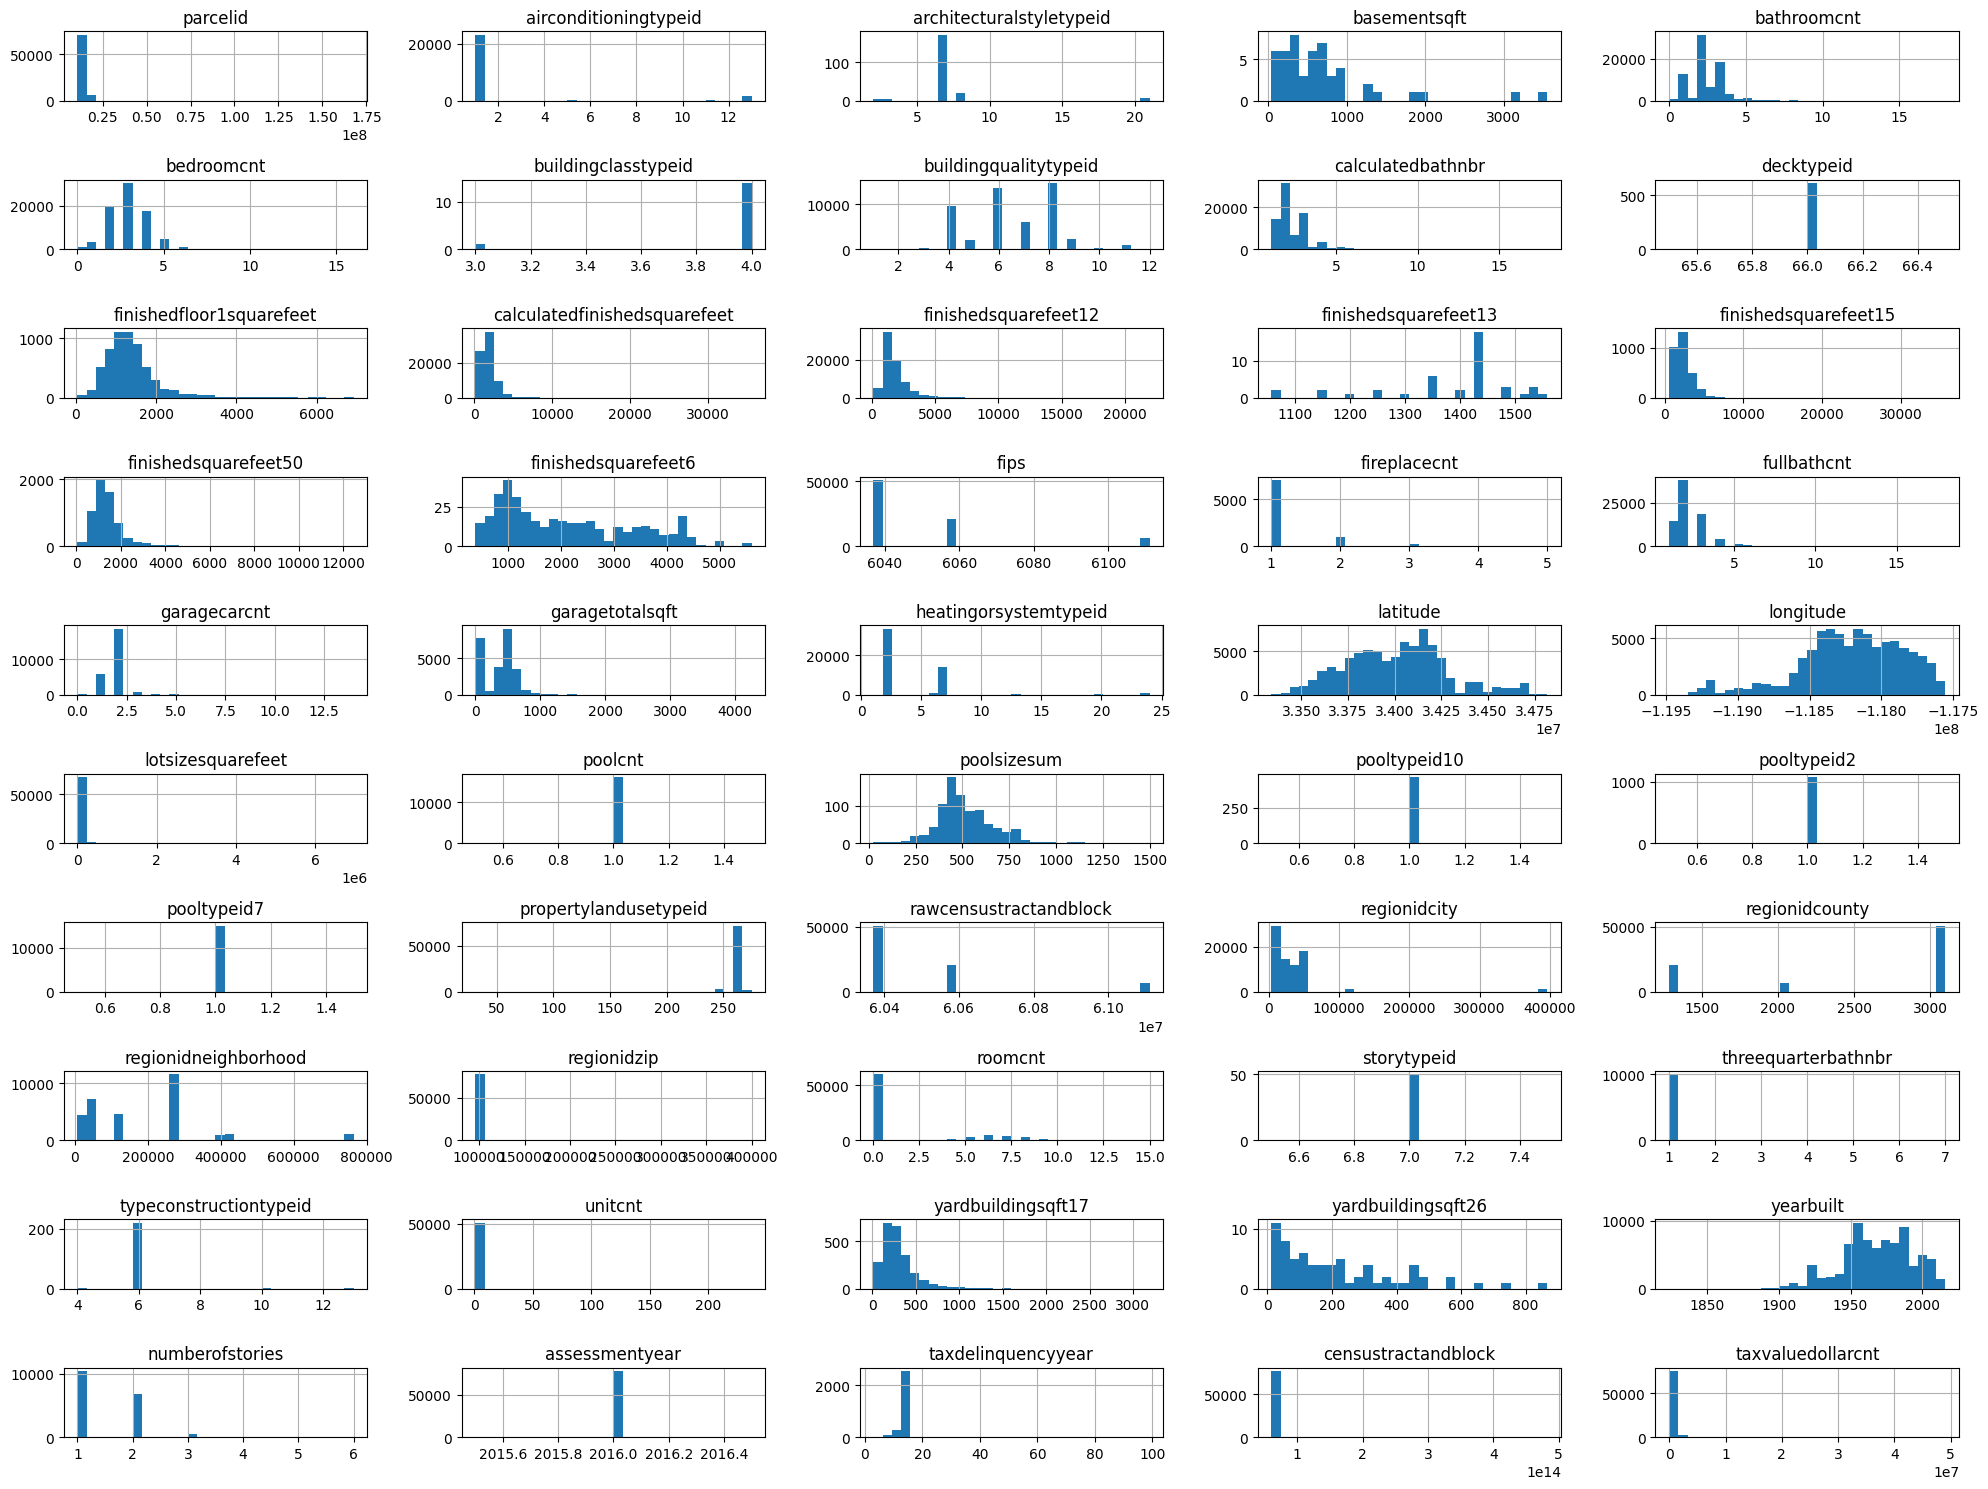

In [ ]:
# histograms for all numeric features
df.hist(figsize=(20, 15), layout=(-1, 5), bins=30)
plt.tight_layout()
plt.show()

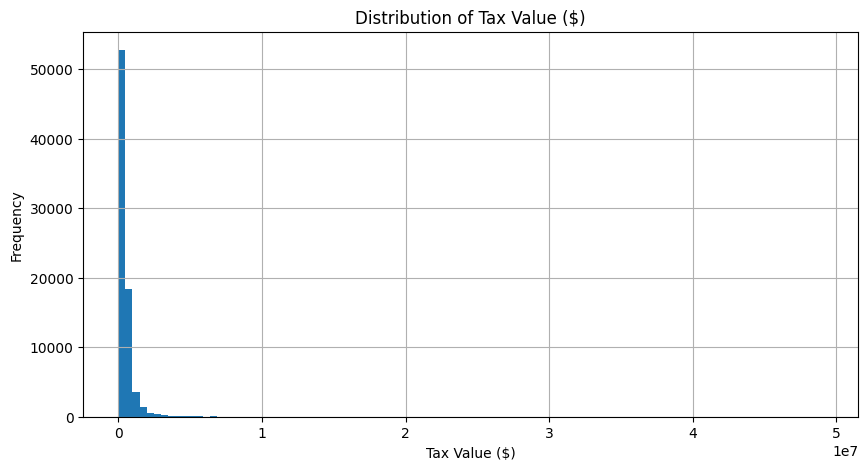

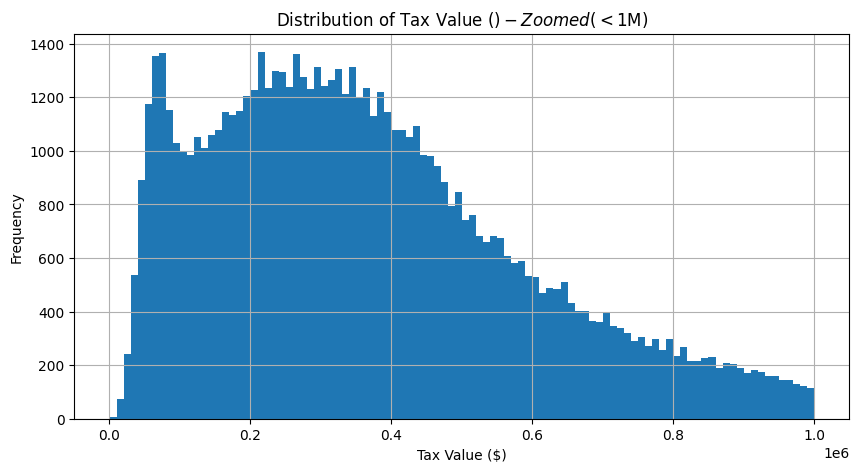

In [ ]:
# distribution of the taxvaluedollarcnt
plt.figure(figsize=(10, 5))
df['taxvaluedollarcnt'].hist(bins=100)
plt.title('Distribution of Tax Value ($) - taxvaluedollarcnt')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# filter extreme outliers
plt.figure(figsize=(10, 5))
df[df['taxvaluedollarcnt'] < 1_000_000]['taxvaluedollarcnt'].hist(bins=100)
plt.title('Distribution of Tax Value ($) taxvaluedollarcnt - Zoomed (< $1M)')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


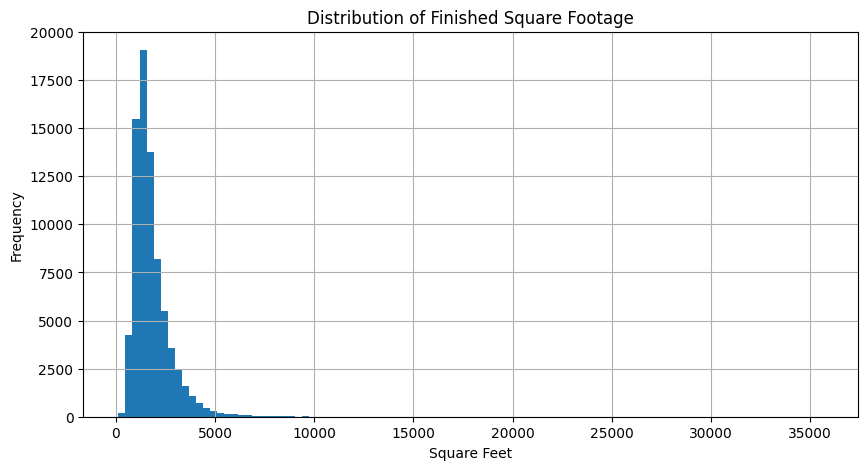

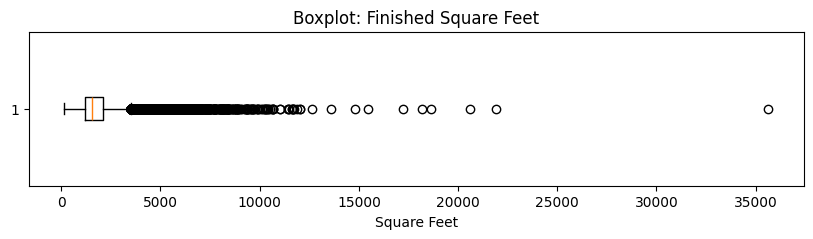

In [35]:
# plotting finishedquarefeet distribution
plt.figure(figsize=(10, 5))
df['calculatedfinishedsquarefeet'].hist(bins=100)
plt.title('Distribution of Finished Square Footage')
plt.xlabel('Square Feet')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# coxplot to check for outliers
plt.figure(figsize=(10, 2))
plt.boxplot(df['calculatedfinishedsquarefeet'].dropna(), vert=False)
plt.title('Boxplot: Finished Square Feet')
plt.xlabel('Square Feet')
plt.show()


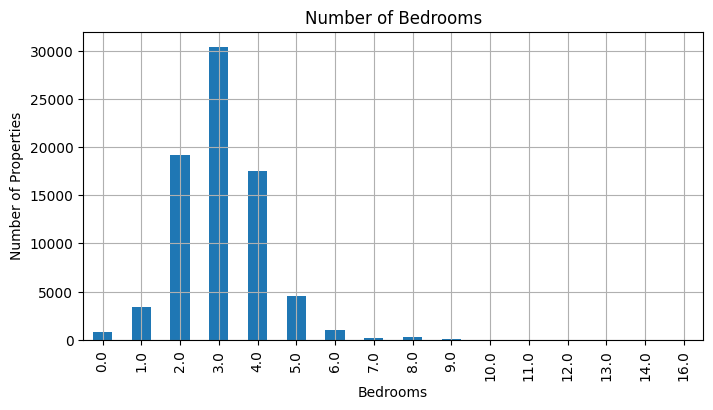

In [36]:
# distribution of bedroom count
plt.figure(figsize=(8, 4))
df['bedroomcnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Number of Properties')
plt.grid(True)
plt.show()

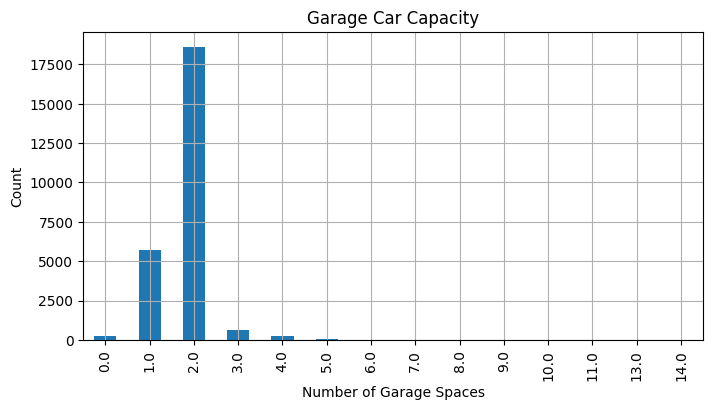

In [37]:
# distribution of garage capacity
plt.figure(figsize=(8, 4))
df['garagecarcnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Garage Car Capacity')
plt.xlabel('Number of Garage Spaces')
plt.ylabel('Count')
plt.grid(True)
plt.show()


#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?

### Answer

The target variable `taxvaluedollarcnt` shows a heavily right-skewed distribution with a long tail extending into multi-million dollar properties. Most homes fall under the $1M mark, and the zoomed-in histogram confirms a dense cluster between $100k and $500k. This skew shows the need for transformation (log scale) or outlier handling when modeling.

The `calculatedfinishedsquarefeet` feature follows a similar right skew distribution - the boxplot highlights some extreme outliers (some over 30,000 sq ft). These may represent either luxury estates, or data entry errors. Despite the outliers, square footage appears to be a strong predictor, as it generally aligns with tax value and home size.

The `bedroomcnt` feature is discrete and normal-shaped, peaking at 3 bedrooms, which can be expected in residential real estate. However, values above 8 bedrooms are rare and could represent some non-standrd properties like multi-family homes or boarding houses, which may call for separate treatment or binning.

`garagecarcnt` is concentrated around 0–2 cars, with very few homes having 4 or more. This makes this a sparse ordinal feature, but its upper tail likely correlates with luxury properties and higher tax values. It's worth keeping, however rare values might benefit from grouping (e.g., 4+ cars).

Overall, I chose these features because they represent structural aspects of a house (size, bedrooms, garage) that intuitively affect home value and are already common in real estate modeling. Their skewed distributions and long tails highlight the need for careful preprocessing before regression modeling, though.


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [ ]:

# drop:
# parcelid
# calculatedbathnbr
# fips
# fireplacecnt
# fullbathcnt
# latitude
# longitude
# propertylandusetypeid
# propertyzoningdesc
# rawcensustractandblock
# regionidcity
# regionidcounty
# regionidneighborhood
# typeconstructiontypeid
# yardbuildingsqft17 - ??
# yardbuildingsqft26 - ??
# taxdelinquencyflag
# taxdelinquencyyear
# censustractandblock

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [ ]:
# 70% is the threshold (i.e. anything with >70% null values, remove those features alltogether)

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

